In [103]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
maindir = "D:/Blood/data" # Directory with files
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [305]:
# Define target columns
target_columns = ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']

# Separate features and targets
X_train = train.drop(columns=target_columns)
X_train.drop(columns=['id'], axis=1, inplace=True)
y_train = train[target_columns + ['donation_id']]

X_test = test.drop(columns=['id'], axis=1)

In [306]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in target_columns:
    encoder = LabelEncoder()
    y_train[col] = encoder.fit_transform(y_train[col])
    encoders[col] = encoder

In [307]:
y_train

,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id
0,1,2,0,2250
1,1,2,0,2250
2,1,2,0,2250
3,1,2,0,2250
4,1,2,0,2250
...,...,...,...,...
29155,1,2,0,1994
29156,1,2,0,1994
29157,1,2,0,1994
29158,1,2,0,1994


In [308]:
from sklearn.metrics import mutual_info_score

# Calculate MI for each pair of targets
for i in range(len(target_columns)):
    for j in range(i + 1, len(target_columns)):
        mi = mutual_info_score(y_train[target_columns[i]], y_train[target_columns[j]])
        print(f"Mutual Information between {target_columns[i]} and {target_columns[j]}: {mi:.2f}")


Mutual Information between hdl_cholesterol_human and hemoglobin(hgb)_human: 0.01
Mutual Information between hdl_cholesterol_human and cholesterol_ldl_human: 0.02
Mutual Information between hemoglobin(hgb)_human and cholesterol_ldl_human: 0.00


In [309]:
# Load mRMR selected features from JSON
with open("selected_features.json", "r") as file:
    selected_features = json.load(file)

In [310]:
# Apply selected features to train and test data
X_train_target1 = X_train[selected_features["Target1"]]
X_train_target2 = X_train[selected_features["Target2"]]
X_train_target3 = X_train[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

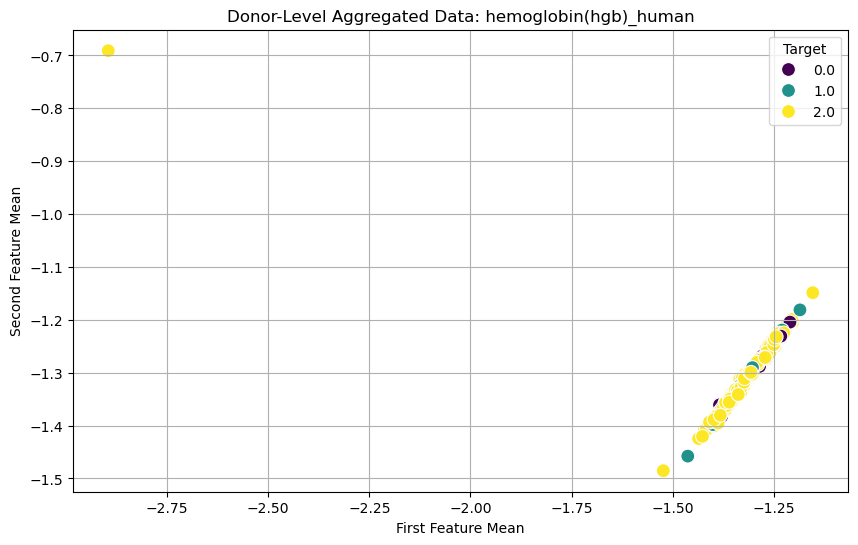

In [311]:
def analyze_donor_level(data, labels, donation_id_column, target_name, std_column=None):
    """
    Analyze donor-level data consistency and variation.

    Parameters:
    - data: Preprocessed spectral data.
    - labels: Corresponding labels for the data.
    - donation_id_column: Column indicating unique donor IDs.
    - target_name: Target variable for analysis.
    - std_column: Column for existing standard deviation in the train set.

    Returns:
    - donor_aggregated: Aggregated donor-level statistics.
    """
    if donation_id_column not in data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    numeric_columns = data.select_dtypes(include="number").columns.tolist()
    if donation_id_column in numeric_columns:
        numeric_columns.remove(donation_id_column)
    if std_column in numeric_columns:
        numeric_columns.remove(std_column)

    donor_means = data.groupby(donation_id_column)[numeric_columns].mean()
    donor_stds = (
        data.groupby(donation_id_column)[numeric_columns].std()
        if std_column is None
        else data.groupby(donation_id_column)[std_column].mean()
    )

    donor_aggregated = pd.concat([donor_means, donor_stds.add_suffix('_std')], axis=1)

    labels_aligned = labels.groupby(data[donation_id_column]).mean()
    donor_aggregated[target_name] = labels_aligned[target_name]

    # Visualize donor-level aggregated statistics
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=donor_aggregated,
        x=donor_aggregated.iloc[:, 0], 
        y=donor_aggregated.iloc[:, 1],  
        hue=donor_aggregated[target_name],
        palette="viridis",
        s=100
    )
    plt.title(f"Donor-Level Aggregated Data: {target_name}")
    plt.xlabel("First Feature Mean")
    plt.ylabel("Second Feature Mean")
    plt.legend(title="Target")
    plt.grid()
    plt.show()
    
    return donor_aggregated

# Example usage
donor_summary_train = analyze_donor_level(
    X_train, y_train, 
    donation_id_column="donation_id",  
    target_name="hemoglobin(hgb)_human",
    std_column="std"  
)


In [118]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

# Redo Stratified K-Fold for each target
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store splits for each target
splits = {}

# Process each target
for target, X_target in target_to_dataset.items():
    
    # Get the corresponding labels
    y_target = y_train[target]
    
    # Compute Stratified K-Fold splits
    splits[target] = list(skf.split(X_target, y_target))

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    # Access target-specific dataset and labels
    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        # Train the model
        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        # Validate the model
        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        # Store fold results
        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")



=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.9304
  Fold 2: Accuracy = 0.9232
  Fold 3: Accuracy = 0.9268
  Fold 4: Accuracy = 0.9299
  Fold 5: Accuracy = 0.9227

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 0.9191
  Fold 2: Accuracy = 0.9306
  Fold 3: Accuracy = 0.9240
  Fold 4: Accuracy = 0.9252
  Fold 5: Accuracy = 0.9234

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.9376
  Fold 2: Accuracy = 0.9328
  Fold 3: Accuracy = 0.9335
  Fold 4: Accuracy = 0.9347
  Fold 5: Accuracy = 0.9338

hdl_cholesterol_human Average Accuracy: 0.9266

hemoglobin(hgb)_human Average Accuracy: 0.9245

cholesterol_ldl_human Average Accuracy: 0.9345


In [139]:
baseline_model_params = {
   'max_depth': 30, 
    'min_samples_leaf': 1,
    'min_samples_split': 16, 
    'n_estimators': 230
}

target_to_dataset = {
    "hdl_cholesterol_human": (X_train_target1, X_test_target1),
    "hemoglobin(hgb)_human": (X_train_target2, X_test_target2),
    "cholesterol_ldl_human": (X_train_target3, X_test_target3),
}

test_predictions = {}

for target, (X_train_target, X_test_target) in target_to_dataset.items():
    print(f"Training model for {target} and predicting on the test set...")

    # Target-specific labels
    y_train_target = y_train[target]

    model = RandomForestClassifier(**baseline_model_params)
    model.fit(X_train_target, y_train_target)

    y_test_pred = model.predict(X_test_target)
    test_predictions[target] = y_test_pred

Training model for hdl_cholesterol_human and predicting on the test set...
Training model for hemoglobin(hgb)_human and predicting on the test set...
Training model for cholesterol_ldl_human and predicting on the test set...


In [140]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [141]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_baseline_optim_new.csv", index=False)

In [63]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Objective function
def objective(params):
    # Unpack hyperparameters
    n_estimators = int(params["n_estimators"])
    max_depth = int(params["max_depth"])
    min_samples_split = int(params["min_samples_split"])
    min_samples_leaf = int(params["min_samples_leaf"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    accuracy = cross_val_score(model, X_train, y_train.iloc[:,0], cv=5, scoring="accuracy").mean()

    # Return negative accuracy (because Hyperopt minimizes)
    return {"loss": -accuracy, "status": STATUS_OK}

In [64]:
# Define the hyperparameter space
search_space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),  
    "max_depth": hp.quniform("max_depth", 5, 50, 5),          
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),  
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1)      
}

In [65]:
trials = Trials()

best_params = fmin(
    fn=objective,                
    space=search_space,          
    algo=tpe.suggest,            # Tree of Parzen Estimators (TPE) algorithm
    max_evals=10,                
    trials=trials,              
    rstate=np.random.default_rng(42)  
)

print("Best Hyperparameters:", best_params)

100%|██████████████████████████████████████████████| 10/10 [22:56<00:00, 137.60s/trial, best loss: -0.5928462709284628]
Best Hyperparameters: {'max_depth': 30.0, 'min_samples_leaf': 1.0, 'min_samples_split': 16.0, 'n_estimators': 230.0}


In [66]:
# Convert best_params to integers (if necessary)
best_params = {
    "n_estimators": int(best_params["n_estimators"]),
    "max_depth": int(best_params["max_depth"]),
    "min_samples_split": int(best_params["min_samples_split"]),
    "min_samples_leaf": int(best_params["min_samples_leaf"]),
}

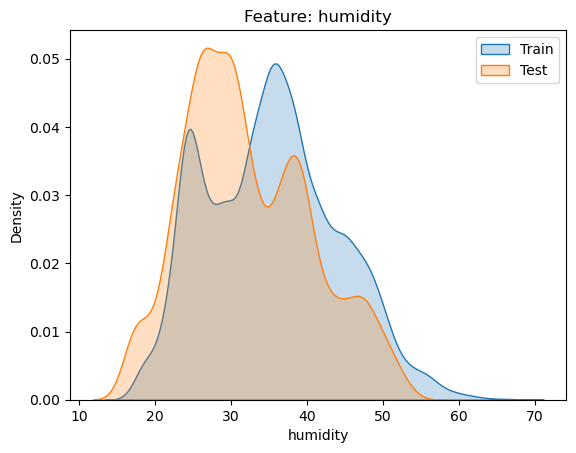

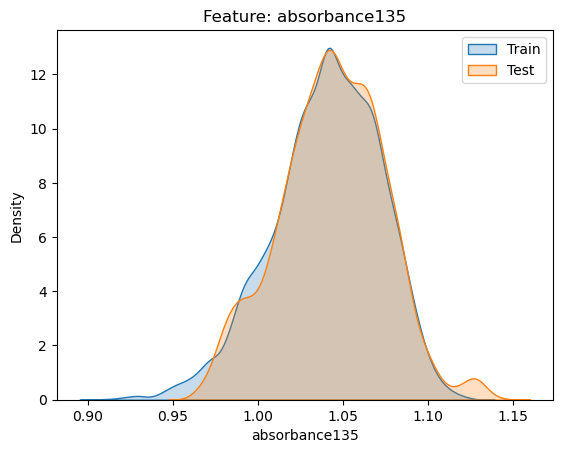

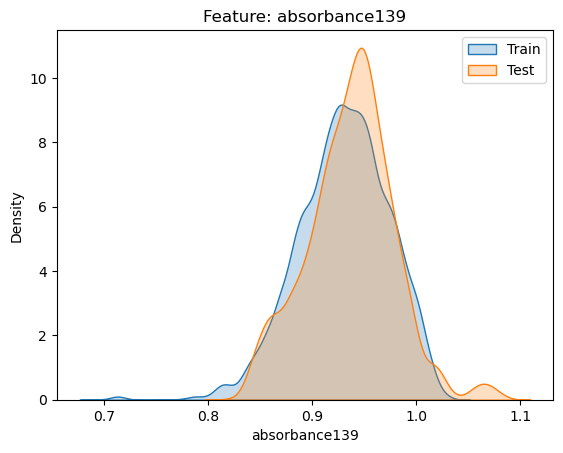

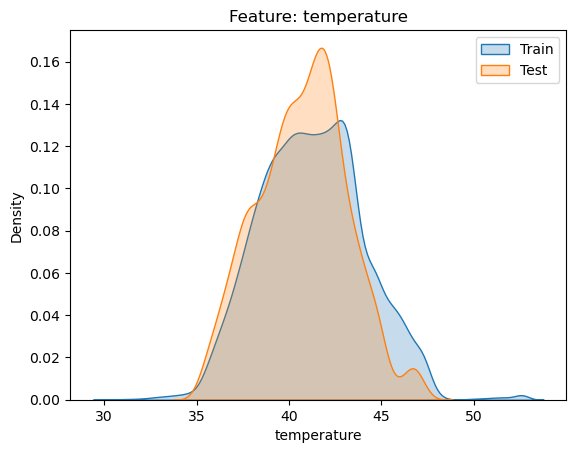

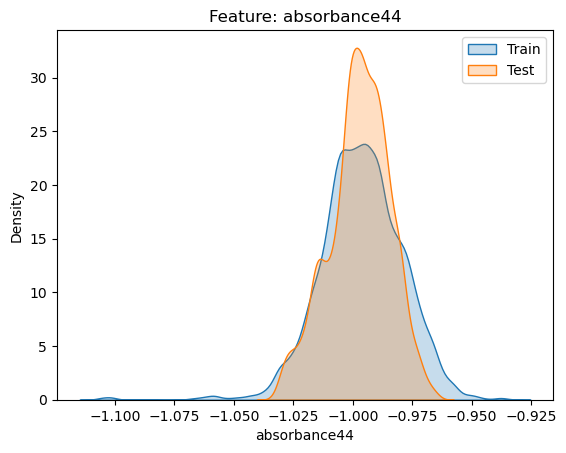

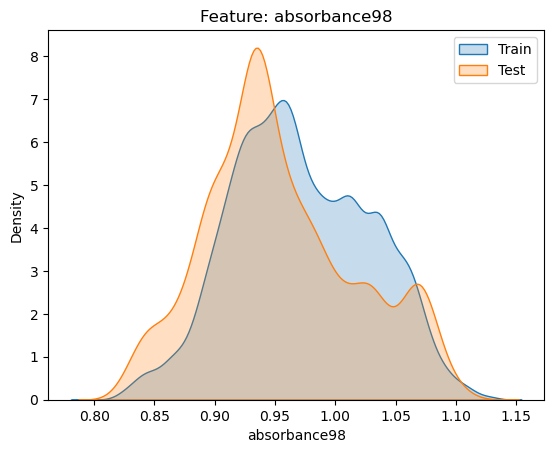

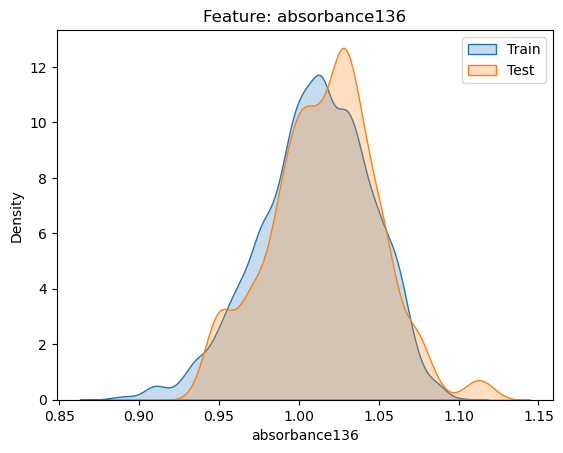

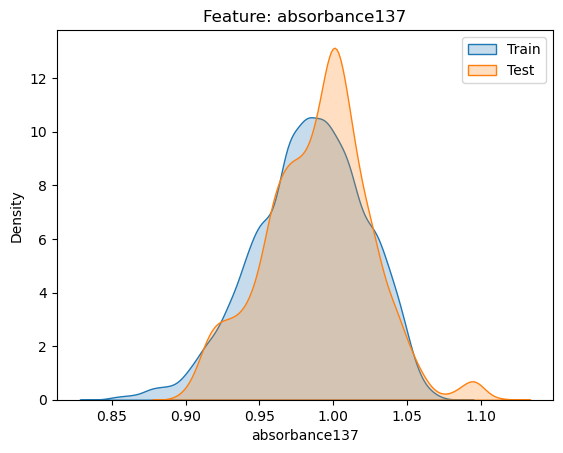

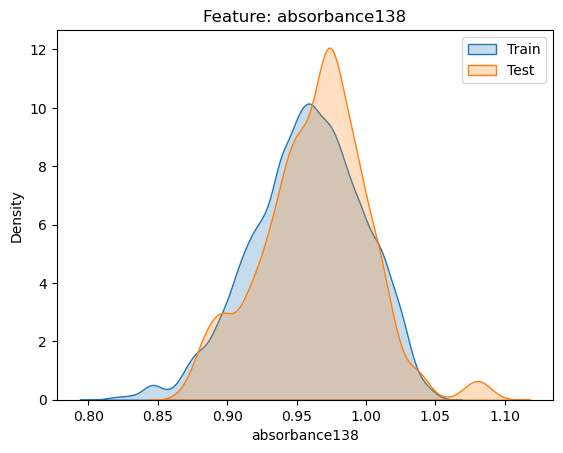

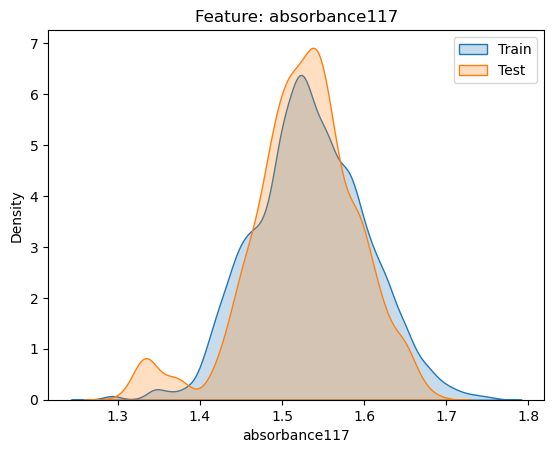

In [312]:
#Distribution 
for column in X_train_target1.columns:
    sns.kdeplot(X_train_target1[column], label='Train', shade=True)
    sns.kdeplot(X_test[column], label='Test', shade=True)
    plt.title(f"Feature: {column}")
    plt.legend()
    plt.show()


In [313]:
from scipy.stats import ks_2samp
for col in X_train_target1.columns.tolist():
    stat, p_value = ks_2samp(X_train_target1[col], X_test[col])
    print(f"KS Statistic for {col}: {stat}, P-value: {p_value}")


KS Statistic for humidity: 0.2029683599811104, P-value: 6.244309073868752e-118
KS Statistic for absorbance135: 0.031085137961276404, P-value: 0.0036492804489457282
KS Statistic for absorbance139: 0.08050889383615556, P-value: 8.789707712507279e-19
KS Statistic for temperature: 0.11260484832130246, P-value: 2.2542029811541353e-36
KS Statistic for absorbance44: 0.0969000877015449, P-value: 4.97360555486702e-27
KS Statistic for absorbance98: 0.17407857158919693, P-value: 1.1851541776473377e-86
KS Statistic for absorbance136: 0.07346747172187362, P-value: 1.0386270501582676e-15
KS Statistic for absorbance137: 0.08349861701409966, P-value: 3.5809988785333035e-20
KS Statistic for absorbance138: 0.08560008095527216, P-value: 3.519649275991232e-21
KS Statistic for absorbance117: 0.06892385706896942, P-value: 7.067441773976222e-14



Visualizing dataset shift for target: hdl_cholesterol_human


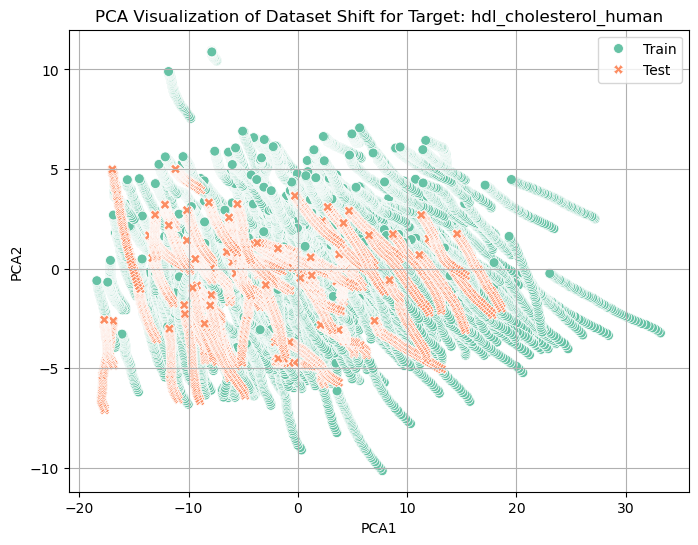


Visualizing dataset shift for target: hemoglobin(hgb)_human


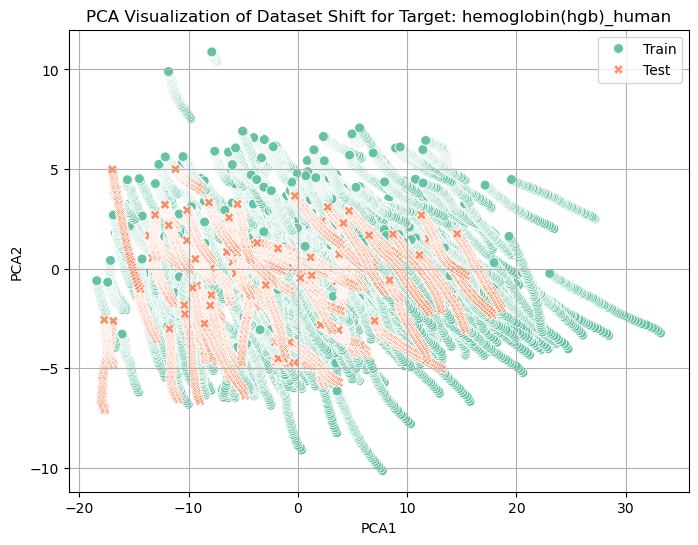


Visualizing dataset shift for target: cholesterol_ldl_human


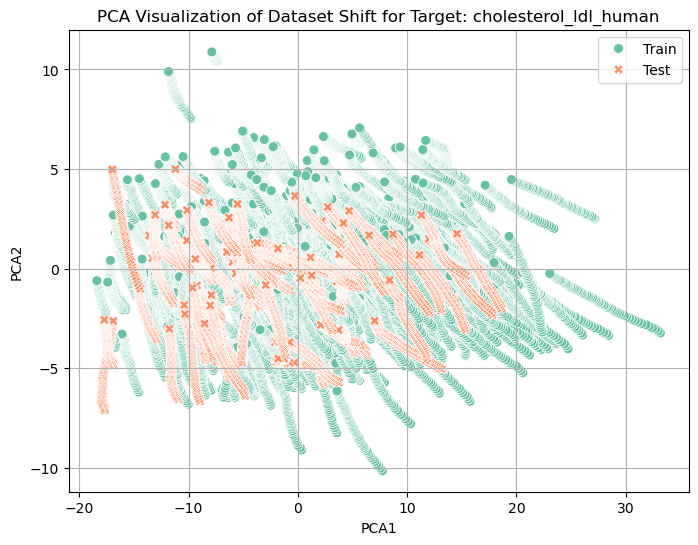

In [314]:
from sklearn.decomposition import PCA

# Function to visualize dataset shifts
def visualize_dataset_shift(X_train, X_test, target_name):
    """
    Visualizes the dataset shift between train and test sets for a given target using PCA.

    Parameters:
    - X_train: Train feature matrix (Pandas DataFrame).
    - X_test: Test feature matrix (Pandas DataFrame).
    - target_name: Name of the target being visualized (string).
    """
    print(f"\nVisualizing dataset shift for target: {target_name}")

    X_train['Dataset'] = 'Train'
    X_test['Dataset'] = 'Test'

    combined_data = pd.concat([X_train, X_test], axis=0)

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(combined_data.drop('Dataset', axis=1))

    pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
    pca_df['Dataset'] = combined_data['Dataset'].values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Dataset', style='Dataset', palette='Set2', s=50)
    plt.title(f"PCA Visualization of Dataset Shift for Target: {target_name}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.grid()
    plt.show()


visualize_dataset_shift(X_train_target1, X_test_target1, "hdl_cholesterol_human")
visualize_dataset_shift(X_train_target2, X_test_target2, "hemoglobin(hgb)_human")
visualize_dataset_shift(X_train_target3, X_test_target3, "cholesterol_ldl_human")


In [277]:
def group_train_data_by_donation_id(train_data, train_labels, donation_id_column, extra_columns):
    """
    Groups train data by `donation_id` and calculates mean for numeric features.

    Parameters:
    - train_data: DataFrame containing features and `donation_id`.
    - train_labels: DataFrame or Series containing target labels.
    - donation_id_column: The column name representing unique donor IDs.
    - target_columns: List of target column names to retain.

    Returns:
    - grouped_train_data: DataFrame with aggregated donor-level features and labels.
    """

    absorbance_columns = [col for col in train_data.columns if 'absorbance' in col and '_std' not in col]
    train_data = train_data[[donation_id_column] + absorbance_columns + extra_columns]

    donor_means = train_data.groupby(donation_id_column)[absorbance_columns + extra_columns].mean()

    labels_aligned = train_labels.groupby(train_data[donation_id_column]).first()  # Use the first label for each donor
    grouped_train_data = donor_means.merge(labels_aligned[target_columns], left_index=True, right_index=True)

    return grouped_train_data

donation_id_column = 'donation_id'   
extra_columns = ['humidity', 'temperature']
# Group train data
grouped_train_data = group_train_data_by_donation_id(X_train, y_train, donation_id_column, extra_columns)

print(f"Grouped train data shape: {grouped_train_data.shape}")


Grouped train data shape: (486, 175)


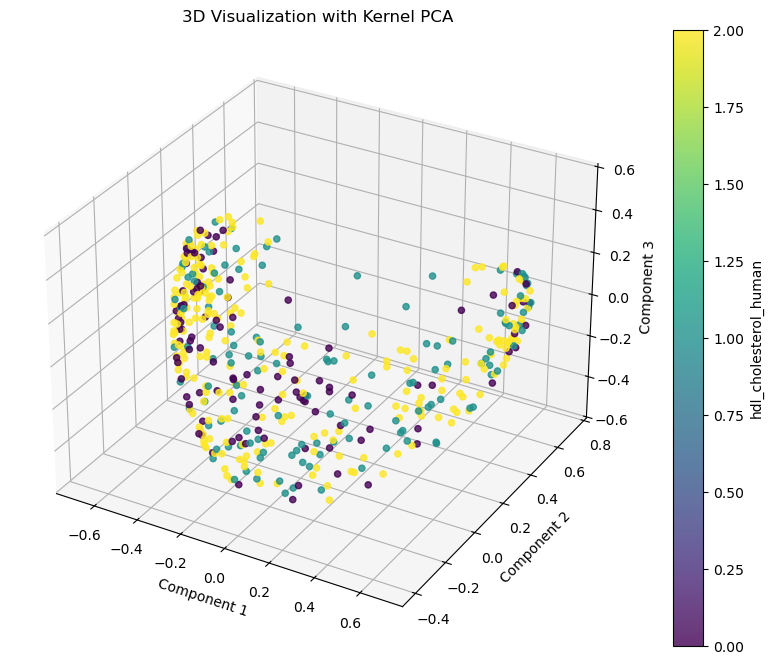

In [279]:
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_nonlinear(data, target_column, n_components=3, kernel='rbf'):
    """
    Perform non-linear dimensionality reduction using Kernel PCA and visualize data in 3D.

    Parameters:
    - data: DataFrame containing the donor-level data (features and target).
    - target_column: Column name of the target variable for color coding.
    - n_components: Number of components for dimensionality reduction (default 3).
    - kernel: Kernel type for Kernel PCA (default 'rbf').

    Returns:
    - None (displays a 3D scatter plot).
    """
   
    features = data.drop(columns=[target_column]).values
    target = data[target_column].values
    
    # Apply Kernel PCA
    kpca = KernelPCA(n_components=n_components, kernel=kernel, random_state=42)
    transformed_features = kpca.fit_transform(features)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        transformed_features[:, 0],
        transformed_features[:, 1],
        transformed_features[:, 2],
        c=target,
        cmap='viridis',
        alpha=0.8
    )
    
    plt.colorbar(scatter, label=target_column)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.set_title("3D Visualization with Kernel PCA")
    plt.show()

visualize_3d_nonlinear(grouped_train_data, target_column='hdl_cholesterol_human')


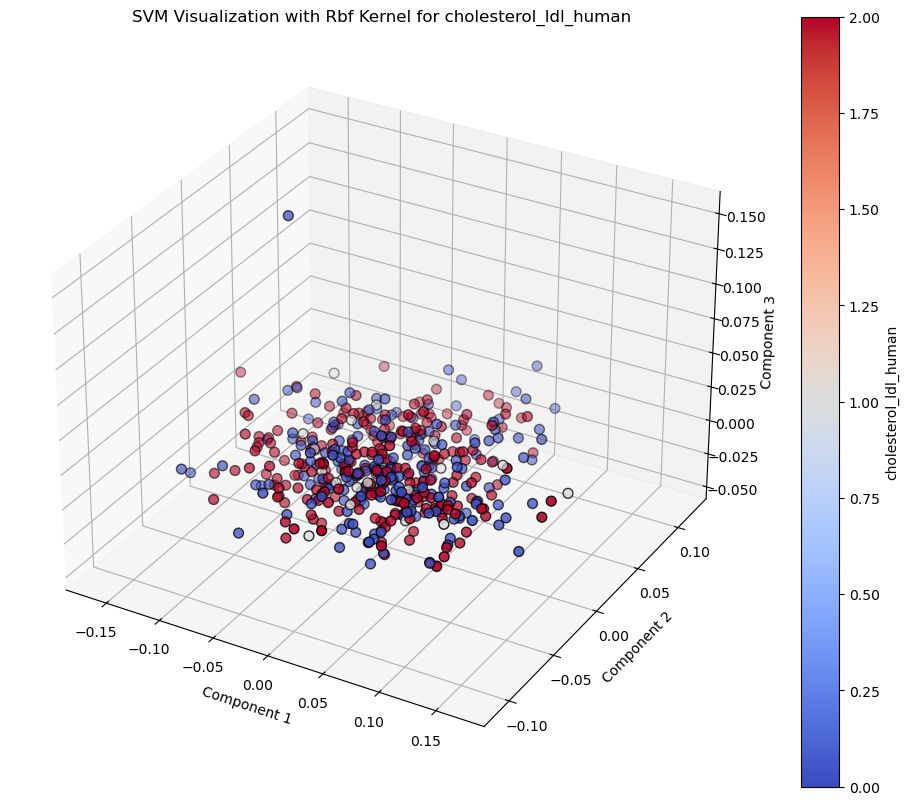

In [247]:
from sklearn.svm import SVC

def visualize_svm_with_kernel_3d(grouped_data, target_column, kernel='rbf'):
    """
    Train and visualize SVM with kernel for grouped data in 3D.

    Parameters:
    - grouped_data: Grouped train data.
    - target_column: Name of the target variable.
    - kernel: Kernel type for SVM (e.g., 'rbf', 'poly').
    """
    features = grouped_data.drop(columns=target_columns)
    target = grouped_data[target_column]

    kpca = KernelPCA(n_components=3, kernel=kernel, random_state=42)
    reduced_features = kpca.fit_transform(features)

    svm_model = SVC(kernel=kernel, gamma='auto', C=1.0)
    svm_model.fit(reduced_features, target)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        reduced_features[:, 2],
        c=target,
        cmap=plt.cm.coolwarm,
        edgecolor='k',
        s=50
    )

    ax.set_title(f"SVM Visualization with {kernel.capitalize()} Kernel for {target_column}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    fig.colorbar(scatter, ax=ax, label=target_column)

    plt.show()

target_column = 'cholesterol_ldl_human'  
visualize_svm_with_kernel_3d(grouped_train_data, target_column, kernel='rbf')


In [269]:
def group_test_data_by_donation_id(test_data, donation_id_column, extra_columns):
    """
    Groups test data by `donation_id` and calculates mean for numeric features, retaining specified extra columns.

    Parameters:
    - test_data: DataFrame containing features and `donation_id`.
    - donation_id_column: The column name representing unique donor IDs.
    - extra_columns: List of extra columns (e.g., humidity, temperature) to retain.

    Returns:
    - grouped_test_data: DataFrame with aggregated donor-level features.
    """
    if donation_id_column not in test_data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    absorbance_columns = [col for col in test_data.columns if 'absorbance' in col]
    test_data = test_data[[donation_id_column] + absorbance_columns + extra_columns]

    donor_means = test_data.groupby(donation_id_column)[absorbance_columns + extra_columns].mean()

    return donor_means


donation_id_column = 'donation_id' 
extra_columns = ['humidity', 'temperature']  
grouped_test_data = group_test_data_by_donation_id(X_test, donation_id_column, extra_columns)

print(f"Grouped test data shape: {grouped_test_data.shape}")


Grouped test data shape: (61, 172)


In [291]:
# Group the targets based on 'donation_id'
def group_targets_by_donation_id(data, target_column, donation_id_column):
    """
    Groups target values by donation_id.

    Parameters:
    - data: DataFrame containing the target values and the donation_id column.
    - target_column: Column name of the target to group.
    - donation_id_column: Column name for grouping.

    Returns:
    - grouped_targets: Series of grouped targets, indexed by donation_id.
    """
    if donation_id_column not in data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    grouped_targets = data.groupby(donation_id_column)[target_column].mean()
    return grouped_targets

# Example usage for each target
grouped_targets = {}
for target_column in ["hdl_cholesterol_human", "hemoglobin(hgb)_human", "cholesterol_ldl_human"]:
    grouped_targets[target_column] = group_targets_by_donation_id(
        y_train,
        target_column=target_column,
        donation_id_column="donation_id"
    )


In [280]:
# Apply selected features to the grouped data
X_train_target1 = grouped_train_data[selected_features["Target1"]]
X_train_target2 = grouped_train_data[selected_features["Target2"]]
X_train_target3 = grouped_train_data[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

In [296]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

splits = {}

for target, X_target in target_to_dataset.items():
    
    y_target = grouped_targets[target]
    
    splits[target] = list(skf.split(X_target, y_target))

In [301]:
baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")


=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.5000
  Fold 2: Accuracy = 0.5876
  Fold 3: Accuracy = 0.5258
  Fold 4: Accuracy = 0.5979
  Fold 5: Accuracy = 0.5773

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 1.0000
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 1.0000
  Fold 5: Accuracy = 1.0000

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.5102
  Fold 2: Accuracy = 0.4742
  Fold 3: Accuracy = 0.5052
  Fold 4: Accuracy = 0.6082
  Fold 5: Accuracy = 0.4536

hdl_cholesterol_human Average Accuracy: 0.5577

hemoglobin(hgb)_human Average Accuracy: 1.0000

cholesterol_ldl_human Average Accuracy: 0.5103
